In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import colormaps
from matplotlib.colors import to_rgb
warnings.filterwarnings('ignore')

In [2]:
ehrshot_dir = '/share/pi/nigam/users/migufuen/ehrshot-benchmark/EHRSHOT_ASSETS/results_ehrshot'

In [3]:
# Wall time dictionary
# (architecture, context length): time to 2b tokens (hours)
wall_time = {
    ('gpt', 512): 23.83,
    ('gpt', 1024): 18.23,
    ('gpt', 2048): 11.62,
    ('gpt', 4096): 10.09,
    ('hyena', 1024): 19.65,
    ('hyena', 4096): 12.03,
    ('hyena', 8192): 9.39,
    ('hyena', 16384): 10.59,
    ('llama', 512): 24.79,
    ('llama', 1024): 17.62,
    ('llama', 2048): 13.68,
    ('llama', 4096): 9.40,
    ('mamba', 1024): 30.65,
    ('mamba', 4096): 12.75,
    ('mamba', 8192): 14.07,
    ('mamba', 16384): 9.63
}

In [4]:
folder_to_name_mapping = {
    'guo_los': 'Long LOS',
    'guo_icu': 'ICU Prediction',
    'guo_readmission': '30-Day Readmission',
    'lab_anemia': 'Anemia',
    'lab_hyperkalemia': 'Hyperkalemia',
    'lab_hypoglycemia': 'Hypoglycemia',
    'lab_hyponatremia': 'Hyponatremia',
    'lab_thrombocytopenia': 'Thrombocytopenia',
    'new_acutemi': 'Acute MI',
    'new_celiac': 'Celiac',
    'new_hyperlipidemia': 'Hyperlipidemia',
    'new_hypertension': 'Hypertension',
    'new_lupus': 'Lupus',
    'new_pancan': 'Pancreatic Cancer',
    'chexpert': 'Chexpert'
}

In [5]:
include_models = [
    'gpt-base-512-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt-base-1024-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt-base-2048-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt-base-4096-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-1024-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-4096-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-8192-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-16384-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-512-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-1024-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-2048-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-4096-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-1024-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-4096-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-8192-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last',
    'mamba-tiny-16384-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-32768-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
]

exclude_tasks = [
    # 'new_lupus',
    # 'new_celiac',
    'chexpert'
]

In [6]:
# Function to clean and extract relevant information from the CSV
def clean_and_extract(df):
    # Select and clean relevant columns, including the replicate column and bounds
    df = df[['sub_task', 'model', 'k', 'score', 'value', 'replicate', 'lower', 'upper']]
    df['model'] = df['model'].str.split('-att--clmbr_train').str[0]
    
    # Filter for AUROC scores
    df = df[(df['k'] == -1) & (df['score'] == 'auroc')]
    
    # Extract architecture and context length
    df['architecture'] = df['model'].apply(lambda x: x.split('-')[0])
    
    # Exclude BERT from the data
    df = df[df['architecture'] != 'bert']
    
    # Extract context length safely and ensure it's an integer
    df['context_length'] = df['model'].apply(lambda x: int(x.split('-')[2]) if len(x.split('-')) > 2 and x.split('-')[2].isdigit() else None)
    
    # Filter out rows related to GPT vocab size variations
    df = df[~df['model'].str.contains('--clmbr-')]
    
    # Group by task, model, architecture, context length, and calculate mean and bounds for replicates
    df_grouped = df.groupby(['sub_task', 'model', 'architecture', 'context_length']).agg(
        value_mean=('value', 'mean'),
        lower_bound=('lower', 'mean'),
        upper_bound=('upper', 'mean')
    ).reset_index()
    
    return df_grouped

In [7]:
# Function to process all tasks and return the combined summary
def process_all_tasks_for_plotting():
    combined_summary = pd.DataFrame()
    for task_name in os.listdir(ehrshot_dir):
        task_path = os.path.join(ehrshot_dir, task_name)
        if os.path.isdir(task_path) and task_name not in exclude_tasks:
                try:
                    print(f"Processing task: {task_name}")
                    # Read and clean data
                    input_file = os.path.join(task_path, 'all_results.csv')
                    df = pd.read_csv(input_file)
                    df = df[df['model'].isin(include_models)]
                    df_cleaned = clean_and_extract(df)
                    df_cleaned['task_name'] = folder_to_name_mapping.get(task_name, task_name)
                    
                    # Map the task name to a human-readable name
                    if task_name == 'chexpert':
                        df_cleaned = df_cleaned.groupby(['architecture', 'context_length', 'model', 'task_name']).agg({
                            'value_mean': 'mean',
                            'lower_bound': 'mean',
                            'upper_bound': 'mean'
                        }).reset_index()
                        df_cleaned['sub_task'] = df_cleaned['task_name']
                    
                    
                    # Combine with the overall summary
                    combined_summary = pd.concat([combined_summary, df_cleaned], ignore_index=True)
                    # print(combined_summary.head())  # Debug: Inspect the first few rows
                    
                except Exception as e:
                    print(f"Failed to process task {task_name}: {e}")
    combined_summary ['architecture'] = combined_summary['architecture'].replace('gpt2', 'gpt')
    df = combined_summary.groupby(['architecture', 'context_length'])['value_mean'].mean().reset_index()
    df['wall_time'] = df.apply(lambda row: wall_time[(row['architecture'], row['context_length'])], axis=1)

    return df

In [8]:
df = process_all_tasks_for_plotting()

Processing task: new_hypertension
Processing task: guo_los
Processing task: lab_hypoglycemia
Processing task: new_lupus
Processing task: lab_hyponatremia
Processing task: new_pancan
Processing task: lab_anemia
Processing task: new_acutemi
Processing task: guo_readmission
Processing task: lab_thrombocytopenia
Processing task: new_hyperlipidemia
Processing task: new_celiac
Processing task: lab_hyperkalemia
Processing task: guo_icu


In [9]:
df

,architecture,context_length,value_mean,wall_time
0,gpt,512,0.790926,23.83
1,gpt,1024,0.776689,18.23
2,gpt,2048,0.786132,11.62
3,gpt,4096,0.776691,10.09
4,hyena,1024,0.789087,19.65
5,hyena,4096,0.792340,12.03
6,hyena,8192,0.784571,9.39
7,hyena,16384,0.728457,10.59
8,llama,512,0.789504,24.79
9,llama,1024,0.799388,17.62


In [10]:
# Define markers for context length
context_markers = {
    512: 'o',     # Circle
    1024: 's',    # Square
    2048: 'D',    # Diamond
    4096: 'x',    # x
    8192: 'v',    # Triangle Down
    16384: '*',   # Star
}

In [11]:
# Use Tab10 colormap for model architectures
cmap = plt.colormaps['tab10']
architecture_colors = {
    'gpt': (cmap(0), [512, 1024, 2048, 4096]),  # Blue
    'llama': (cmap(1), [512, 1024, 2048, 4096]),  # Orange
    'mamba': (cmap(2), [1024, 4096, 8192, 16384]),  # Green
    'hyena': (cmap(3), [1024, 4096, 8192, 16384])   # Red
}

In [12]:
def generate_shades(architecture_colors, light=True):
    """
    Generate lighter or darker shades of a given base color.
    
    Parameters:
        architecture_colors (tuple): Map with base color and context lengths
        light (bool): Generate lighter shades if True, darker shades if False.
        
    Returns:
        list: List of RGB tuples representing the shades.
    """
    color_shades = {}
    for architecture, (color, context_lengths) in architecture_colors.items():
        print(architecture)
        print(context_lengths)
        base_color_rgb = to_rgb(color)  # Convert to RGB
        color_shades[architecture] = {}
        for i, context_length in enumerate(reversed(context_lengths)):
            factor = i / (len(context_lengths) + 1)
            if light:
                # Interpolate with white
                shade = [(1 - factor) * c + factor for c in base_color_rgb]
            else:
                # Interpolate with black
                shade = [factor * c for c in base_color_rgb]
            color_shades[architecture][context_length] = tuple(shade)
    return color_shades

color_shades = generate_shades(architecture_colors)

gpt
[512, 1024, 2048, 4096]
llama
[512, 1024, 2048, 4096]
mamba
[1024, 4096, 8192, 16384]
hyena
[1024, 4096, 8192, 16384]


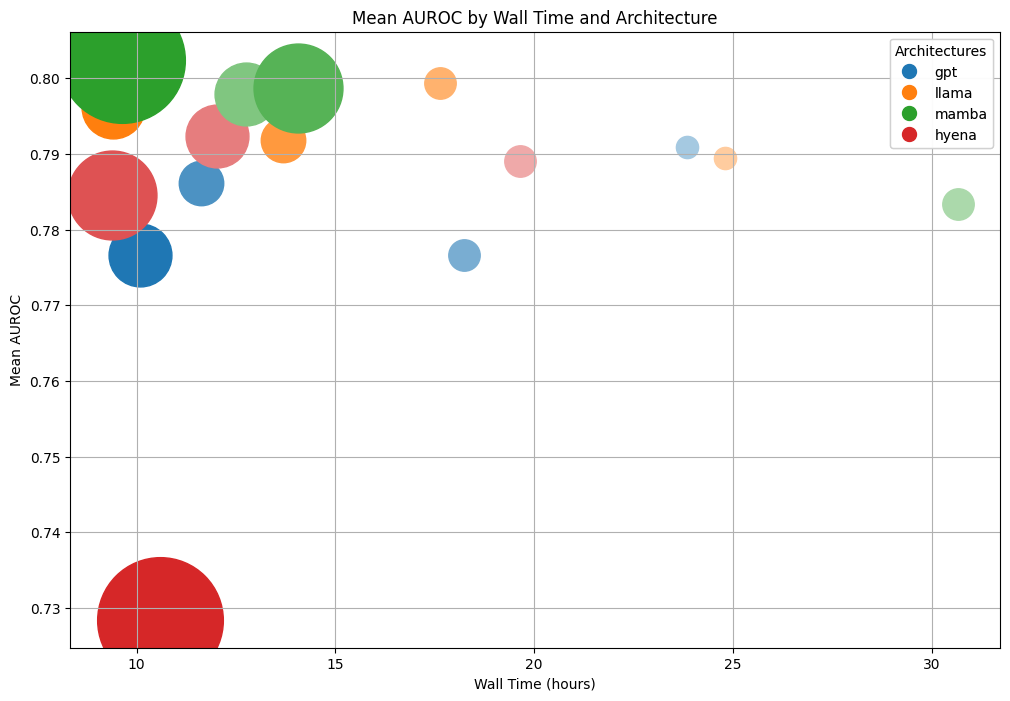

In [13]:
# Create the plot
plt.figure(figsize=(12, 8))

# Plot each point with the corresponding color and marker
for _, row in df.iterrows():
    plt.scatter(
        row['wall_time'], 
        row['value_mean'], 
        color=color_shades[row['architecture']][row['context_length']], 
        # marker=context_markers[row['context_length']], 
        marker='o', 
        s=0.5 * row['context_length']
    )

# Add axis labels and title
plt.xlabel("Wall Time (hours)")
plt.ylabel("Mean AUROC")
plt.title("Mean AUROC by Wall Time and Architecture")

# Create a legend for colors (architectures)
color_handles = [
    plt.Line2D([], [], color=val[0], marker='o', linestyle='', markersize=10, label=arch)
    for arch, val in architecture_colors.items()
]
color_legend = plt.legend(handles=color_handles, title="Architectures", loc="upper right", bbox_to_anchor=(1, 1))

# Add the color legend to the plot
plt.gca().add_artist(color_legend)

plt.grid(True)

# Show the plot
plt.show()